In [379]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import jax.scipy as jsp 
plt.rc("figure", figsize=[6,6], dpi=150, facecolor='w')
import numpy as np

rng = np.random.default_rng(4)

In [412]:
@jax.vmap
def TT(s):
    theta = jnp.arctan(s[1]/s[0])
    r = ((s[0]**2 + s[1]**2)**.5)/2
    T = jnp.array([[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]])@jnp.array([[1/r,0],[0,r/2]])
    return T@T.T

In [413]:
@jax.vmap
def cov_gen(means):
    return jnp.where(
        means.prod()>=0, 
        jnp.abs(jnp.array([[means[1], means[0]],[means[0], means[1]]])) + 1e-2,
        jnp.array([[abs(means[1]), means[0]],[means[0], abs(means[1])]]) + 1e-2
    )

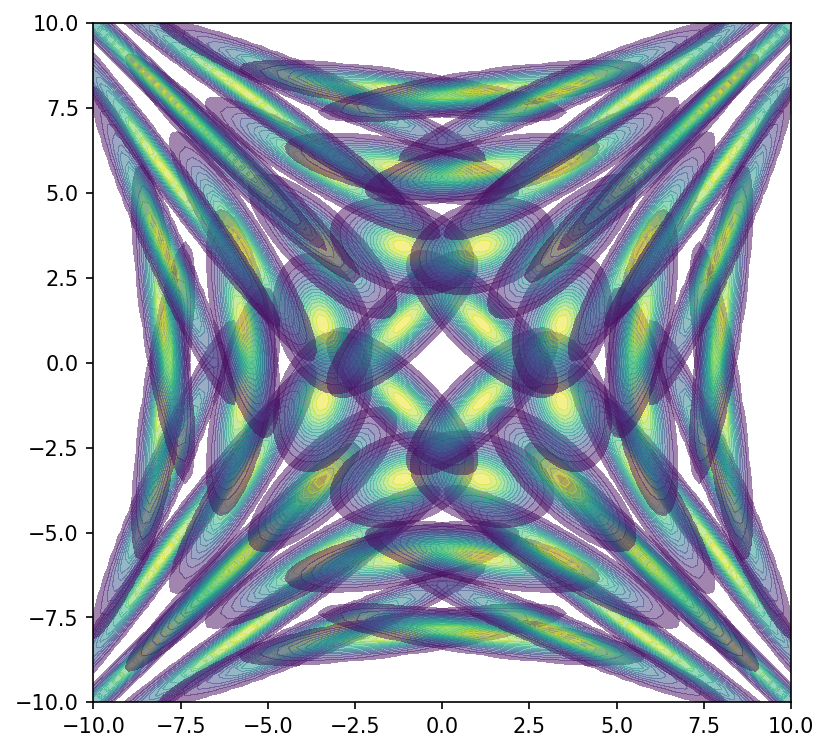

In [417]:

def xy_pairs(nx, ny, span):
    size = nx, ny
    x_grid = jnp.linspace(-span, span, nx)
    y_grid = jnp.linspace(-span, span, ny)
    xx, yy = jnp.meshgrid(x_grid, y_grid)
    return jnp.hstack((xx.reshape(-1,1), yy.reshape(-1,1))), size, xx, yy

xy_pairs_eval, grid_size, xx, yy = xy_pairs(100,100, 10)
means, g, xx2, yy2 = xy_pairs(8,8, 8)
covs = TT(means)

def gaussian_2d_pdf(eval_points, mean, cov):
    return jsp.stats.multivariate_normal.pdf(eval_points, mean=mean, cov=cov)

vmapped_pdf = jax.vmap(gaussian_2d_pdf, in_axes=(None, 0, 0))

# covs = jnp.array([[[1, 0],[3,3]] for _ in means])
pdfs = vmapped_pdf(xy_pairs_eval, means, covs).reshape(len(means), *grid_size) 

fig, ax = plt.subplots()
for pdf in pdfs:
    step = 0.02
    m = jnp.amax(pdf)
    levels = jnp.arange(0.0, m, step) + step
    ax.contourf(xx, yy, pdf,  alpha=0.5, cmap="viridis",levels=levels,)
# ax.scatter(xx2, yy2)


In [418]:
from jax.random import multivariate_normal, PRNGKey

@jax.vmap
def samples(mean, cov):
    return multivariate_normal(PRNGKey(0), mean, cov, shape=(10000,))

samps = samples(means, covs)
samps.shape

(64, 10000, 2)

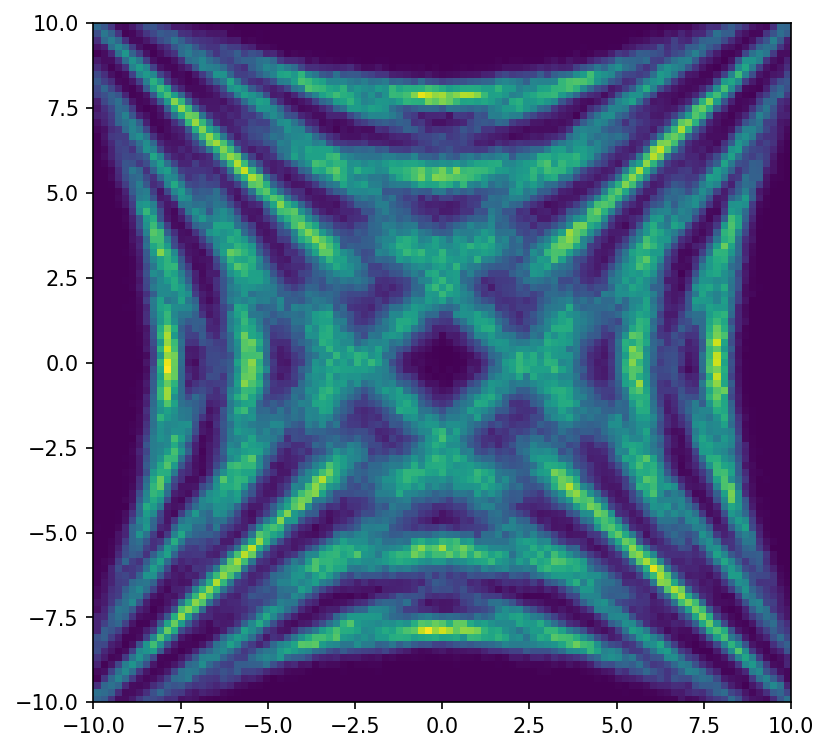

In [419]:
from plothelp import autogrid

fig, ax = plt.subplots()

bins = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)


def plot(ax, s, i):
    x, y = s[:,0], s[:,1]
    ax.hist2d(x,y, density=True, bins=bins)
    ax.set_xlim((-10,10))
    ax.set_ylim((-10,10))

data = jnp.concatenate(samps)
plot(ax, data, 0)
# autogrid(
#     samps,
#     plot,
#     # subplot_kwargs=dict(sharex=True, sharey=True),
#     plots_per_row=7
# );
